# Image Captioning with LSTM

This is a partial implementation of "Show and Tell: A Neural Image Caption Generator" (http://arxiv.org/abs/1411.4555), borrowing heavily from Andrej Karpathy's NeuralTalk (https://github.com/karpathy/neuraltalk)

This example consists of three parts:
1. COCO Preprocessing - prepare the dataset by precomputing image representations using GoogLeNet
2. RNN Training - train a network to predict image captions
3. Caption Generation - use the trained network to caption new images

### Output
This notebook prepares the dataset by extracting a vector representation of each image using the GoogLeNet CNN pretrained on ImageNet. A link to download the final result is given in the next notebook.


### Prerequisites

To run this notebook, you'll need to download the MSCOCO [training](http://msvocds.blob.core.windows.net/coco2014/train2014.zip) and [validation](http://msvocds.blob.core.windows.net/coco2014/val2014.zip) datasets, and unzip them into './coco/'.

The [captions](http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip) should be downloaded as well and unzipped into './captions/'

In [1]:
import sklearn
import numpy as np
import lasagne
import skimage.transform

from lasagne.utils import floatX

import theano
import theano.tensor as T

import matplotlib.pyplot as plt
%matplotlib inline

import json
import pickle

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled)


Functions for building the GoogLeNet model with Lasagne are defined in googlenet.py:

In [2]:
import googlenet

We need to download parameter values for the pretrained network

In [3]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/blvc_googlenet.pkl

--2015-08-28 16:43:21--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/blvc_googlenet.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.32.248
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.32.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28029725 (27M) [binary/octet-stream]
Saving to: ‘blvc_googlenet.pkl’

100%[======================================>] 28,029,725  10.2MB/s   in 2.6s   

2015-08-28 16:43:24 (10.2 MB/s) - ‘blvc_googlenet.pkl’ saved [28029725/28029725]



Build the model and select layers we need - the features are taken from the final network layer, before the softmax nonlinearity.

In [5]:
cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['loss3/classifier']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

Load the pretrained weights into the network

In [6]:
model_param_values = pickle.load(open('blvc_googlenet.pkl'))['param values']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

The images need some preprocessing before they can be fed to the CNN

In [7]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    # Resize so smallest dim = 224, preserving aspect ratio
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (224, w*224/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*224/w, 224), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

Let's verify that GoogLeNet and our preprocessing are functioning properly

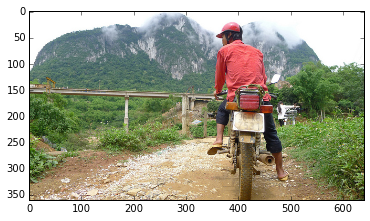

In [8]:
im = plt.imread('./coco/val2014/COCO_val2014_000000391895.jpg')
plt.imshow(im)

In [9]:
rawim, cnn_im = prep_image(im)

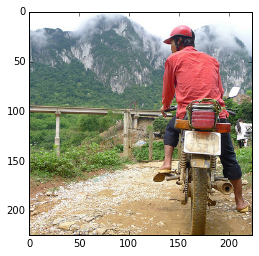

In [10]:
plt.imshow(rawim)

In [11]:
p = get_cnn_features(cnn_im)
CLASSES = pickle.load(open('blvc_googlenet.pkl'))['synset words']
print(CLASSES[p.argmax()])

mountain bike, all-terrain bike, off-roader


Load the caption data

In [12]:
dataset = json.load(open('./captions/dataset_coco.json'))['images']

Iterate over the dataset and add a field 'cnn features' to each item. This will take quite a while.

In [259]:
def chunks(l, n):
    for i in xrange(0, len(l), n):
        yield l[i:i + n]

for chunk in chunks(dataset, 256):
    cnn_input = floatX(np.zeros((len(chunk), 3, 224, 224)))
    for i, image in enumerate(chunk):
        fn = './coco/{}/{}'.format(image['filepath'], image['filename'])
        try:
            im = plt.imread(fn)
            _, cnn_input[i] = prep_image(im)
        except IOError:
            continue
    features = get_cnn_features(cnn_input)
    for i, image in enumerate(chunk):
        image['cnn features'] = features[i]

Save the final product

In [279]:
pickle.dump(dataset, open('coco_with_cnn_features.pkl','w'), protocol=pickle.HIGHEST_PROTOCOL)